In [0]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import resize
from torch.utils.data import DataLoader
import itertools
import os
import matplotlib.pyplot as plt
import bs4
import requests
import json
IMG_SIZE = 256

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#create model

In [0]:
class ResnetBlock(nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(layer_size, layer_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(layer_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(layer_size, layer_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(layer_size),
        )
    
    def forward(self, inp):
        return(inp + self.block(inp))

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        model = []

        n_downsampling = 3
        layer_size = 32


        model += [nn.Conv2d(3, layer_size, kernel_size=7, padding=3)
                  
        ]


        for i in range(n_downsampling):
            prev_layer_size = layer_size
            layer_size *= 2
            model += [nn.Conv2d(prev_layer_size, layer_size, kernel_size=3, stride=2, padding=1),
                      nn.BatchNorm2d(layer_size),
                      nn.ReLU(inplace=True)
                                      
            ]
        

        prev_layer_size = layer_size
        n_blocks = 5
        for i in range(n_blocks):
            model += [ResnetBlock(prev_layer_size)]


        n_upsampling = n_downsampling  
        for i in range(n_upsampling):
            layer_size = prev_layer_size // 2
            model += [nn.ConvTranspose2d(prev_layer_size, layer_size, kernel_size=3, stride=2, padding=1, output_padding=1),
                      nn.BatchNorm2d(layer_size),
                      nn.ReLU(inplace=True),                      
            ]
            prev_layer_size //= 2


        model += [nn.Conv2d(prev_layer_size, 3, kernel_size=7, stride=1, padding=3),
                  nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)



    def forward(self, inp):
        return(self.model(inp))

In [0]:
class Discriminator(nn.Module):
    def __init__(self, n_layers=3):
        super().__init__()

        sequence = []
        prev_layer_size = 3
        layer_size = 64

        sequence = [nn.Conv2d(3, layer_size, kernel_size=4, padding=1, stride=2), 
                    nn.LeakyReLU(0.2, inplace=True),
        ]

        for i in range(n_layers - 1):
            prev_layer_size = layer_size
            layer_size *= 2
            sequence += [nn.Conv2d(in_channels=prev_layer_size, out_channels=layer_size, kernel_size=4, padding=1, stride=2),
                         nn.BatchNorm2d(layer_size),
                         nn.LeakyReLU(0.2, inplace=True),
            ]

        prev_layer_size = layer_size
        layer_size *= 2
        sequence += [nn.Conv2d(in_channels=prev_layer_size, out_channels=layer_size, kernel_size=4, padding=1, stride=1),
                     nn.BatchNorm2d(layer_size),
                     nn.LeakyReLU(0.2, inplace=True),
        ]

        sequence += [nn.Conv2d(in_channels=layer_size, out_channels=1, kernel_size=4, padding=1, stride = 1)]

        self.model = nn.Sequential(*sequence)
    


    def forward(self, input):
        return(self.model(input))

![alt text](https://hsto.org/webt/59/e4/27/59e42744848e6728090234.png)

In [0]:
class CycleGan():
    def __init__(self, img_size, mode='create', path=None):
        if mode == 'create':
            self.G_X_Y = Generator().to(device)
            self.D_X_Y = Discriminator().to(device)
            self.G_Y_X = Generator().to(device)
            self.D_Y_X = Discriminator().to(device)
        elif mode == 'load':
            self.load_models(path)
        else:
            print('Mode name is not correct')
            raise(NameError)

        self.BCEloss = nn.BCEWithLogitsLoss()
        self.L1Loss = nn.L1Loss()


    
    def save_models(self, path):
        torch.save(self.G_X_Y, path + '/G_X_Y')
        torch.save(self.G_Y_X, path + '/G_Y_X')
        torch.save(self.D_X_Y, path + '/D_X_Y')
        torch.save(self.D_Y_X, path + '/D_Y_X')
    


    def load_models(self, path):
        self.G_X_Y = torch.load(path + '/G_X_Y')
        self.G_X_Y.train()
        self.G_Y_X = torch.load(path + '/G_Y_X')
        self.G_Y_X.train()
        self.D_X_Y = torch.load(path + '/D_X_Y')
        self.D_X_Y.train()
        self.D_Y_X = torch.load(path + '/D_Y_X')
        self.D_Y_X.train()
        


    def set_requires_grad(self, models, value):
        for model in models:
            for param in model.parameters():
                param.requires_grad = value



    def gan_criterion(self, prediction, is_true):
        if is_true:
            target_tensor = torch.tensor(1.0).expand_as(prediction)
        else:
            target_tensor = torch.tensor(0.0).expand_as(prediction)

        loss = self.BCEloss(prediction.cpu(), target_tensor.cpu())

        return(loss.to(device))



    def discriminators_backward(self, discriminator_X_Y, discriminator_Y_X, fake_X, fake_Y, real_X, real_Y):
        real_D_X_Y_loss = self.gan_criterion(discriminator_X_Y(real_Y), True)
        fake_D_X_Y_loss = self.gan_criterion(discriminator_X_Y(fake_Y.detach()), False)
        self.loss_D_X_Y = real_D_X_Y_loss + fake_D_X_Y_loss
        self.loss_D_X_Y.backward()

        real_D_Y_X_loss = self.gan_criterion(discriminator_Y_X(real_X), True)
        fake_D_Y_X_loss = self.gan_criterion(discriminator_Y_X(fake_X.detach()), False)
        self.loss_D_Y_X = real_D_Y_X_loss + fake_D_Y_X_loss
        self.loss_D_Y_X.backward()
        return(real_D_X_Y_loss, fake_D_X_Y_loss)



    def generators_backward(self, generator_X_Y, discriminator_X_Y, generator_Y_X, discriminator_Y_X, fake_X, fake_Y, real_X, real_Y, comp_X, comp_Y, lmb):
        gan_loss_X_Y = self.gan_criterion(discriminator_X_Y(fake_Y), True)
        gan_loss_Y_X = self.gan_criterion(discriminator_Y_X(fake_X), True)

        cycle_loss_X_Y = self.L1Loss(comp_X, real_X) * lmb
        cycle_loss_Y_X = self.L1Loss(comp_Y, real_Y) * lmb

        #identy_loss_X_Y = self.L1Loss(generator_X_Y(real_Y), real_Y) * lmb
        #identy_loss_Y_X = self.L1Loss(generator_Y_X(real_X), real_X) * lmb

        self.G_loss = gan_loss_X_Y + gan_loss_Y_X + cycle_loss_X_Y + cycle_loss_Y_X
        self.G_loss.backward()



    def train(self, data_loader, epochs, lr, lmb, test_set):
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.G_X_Y.parameters(), self.G_Y_X.parameters()), lr=lr)
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.D_X_Y.parameters(), self.D_Y_X.parameters()), lr=lr)
        test_set = test_set.to(device)
        show_rate = epochs // 100
        counter = 0


        for epoch in range(epochs):
            real_loss_list = []
            fake_loss_list = []
            for X_batch, Y_batch in data_loader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                self.fake_Y = self.G_X_Y(X_batch)  # G(X)
                self.comp_X = self.G_Y_X(self.fake_Y)   # F(G(X))
                self.fake_X = self.G_Y_X(Y_batch)  # F(Y)
                self.comp_Y = self.G_X_Y(self.fake_X)   # G(F(Y))
                # generator
                self.set_requires_grad([self.D_X_Y, self.D_Y_X], False)
                self.optimizer_G.zero_grad()
                self.generators_backward(self.G_X_Y, self.D_X_Y, self.G_Y_X, self.D_Y_X, self.fake_X, self.fake_Y, X_batch, Y_batch, self.comp_X, self.comp_Y, lmb)
                self.optimizer_G.step()
                # discriminator
                self.set_requires_grad([self.D_X_Y, self.D_Y_X], True)
                self.optimizer_D.zero_grad()
                real_loss, fake_loss = self.discriminators_backward(self.D_X_Y, self.D_Y_X, self.fake_X, self.fake_Y, X_batch, Y_batch)
                real_loss_list.append(real_loss.detach().cpu().item())
                fake_loss_list.append(fake_loss.detach().cpu().item())
                self.optimizer_D.step()


            if counter % show_rate == 0:
                print('{0}/{1}'.format(counter + 1, epochs))
                print(sum(real_loss_list) / len(real_loss_list), sum(fake_loss_list) / len(fake_loss_list))
                test_set_output = self.G_X_Y(test_set)
                for i in range(4):
                    plt.subplot(2, 4, i+1)
                    plt.imshow(np.rollaxis(test_set[i].detach().cpu().numpy(), 0, 3))
                    plt.axis('off')
                    plt.subplot(2, 4, i+5)
                    plt.imshow(np.rollaxis(test_set_output[i].detach().cpu().numpy(), 0, 3))
                    plt.axis('off')
                plt.show()


            counter += 1

#load apple2orange data

In [0]:
apple_images = []
orange_images = []

root = 'cycle_gan_datasets'
for root, dirs, files in os.walk(os.path.join(root, 'apple2orange\\trainA')):
    for fil in files:
        apple_images.append(imread(os.path.join(root, fil)))

root = 'cycle_gan_datasets'
for root, dirs, files in os.walk(os.path.join(root, 'apple2orange\\trainB')):
    for fil in files:
        orange_images.append(imread(os.path.join(root, fil)))

In [0]:
size = (IMG_SIZE, IMG_SIZE)
apple_images = np.array([resize(img, size, mode='constant', anti_aliasing=True) for img in apple_images], np.float32)
orange_images = np.array([resize(img, size, mode='constant', anti_aliasing=True) for img in orange_images], np.float32)

In [0]:
if len(apple_images) > len(orange_images):
    apple_images = apple_images[:len(orange_images)]
else:
    orange_images = orange_images[:len(apple_images)]

In [0]:
batch_size = 10
apple2orange_data_loader = DataLoader(list(zip(np.rollaxis(apple_images, 3, 1), np.rollaxis(orange_images, 3, 1))), batch_size=batch_size, shuffle=True)

#apple2orange training

In [0]:
X_test_set, Y_test_set = next(iter(data_loader))

In [0]:
gan_net = CycleGan(img_size=IMG_SIZE, mode='create')

In [0]:
gan_net.train(data_loader=apple2orange_data_loader, epochs=700, lr=0.0001, lmb=10, test_set=X_test_set)

In [0]:
gan_net.save_models(path='cycle_gan_models/apple2orange_model')

In [0]:
apple2orange_model = CycleGan(img_size=IMG_SIZE, mode='load', path='cycle_gan_models/apple2orange_model')

In [0]:
Y_ret = apple2orange_model.G_X_Y(X_test_set.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


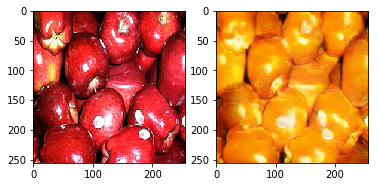

In [0]:
img_n = 0 
plt.subplot(1, 2, 1)
plt.imshow(np.rollaxis(X_test_set[img_n].detach().cpu().numpy(), 0, 3))
plt.subplot(1, 2, 2)
plt.imshow(np.rollaxis(Y_ret[img_n].detach().cpu().numpy(), 0, 3))

#load people2dicaprio data

In [0]:
people_f = open('web_pages/people.html', 'rb')
people_data = people_f.read()
people_soup = bs4.BeautifulSoup(people_data, 'html.parser')
people_f.close()

dicaprio_f = open('web_pages/dicaprio.html', 'rb')
dicaprio_data = dicaprio_f.read()
dicaprio_soup = bs4.BeautifulSoup(dicaprio_data, 'html.parser')
dicaprio_f.close()

In [0]:
n_images = 1400
people_images = []
dicaprio_images = []
for i in range(n_images):
    people_finded = people_soup.find_all(class_ = 'serp-item_pos_{0}'.format(i+1))
    dicaprio_finded = dicaprio_soup.find_all(class_ = 'serp-item_pos_{0}'.format(i+1))
    try:
        if (people_finded != []) & (dicaprio_finded != []):
            people_img_link = json.loads(people_finded[0].attrs['data-bem'])['serp-item']['img_href']
            dicaprio_img_link = json.loads(dicaprio_finded[0].attrs['data-bem'])['serp-item']['img_href']
            people_images.append(imread(people_img_link))
            dicaprio_images.append(imread(dicaprio_img_link))
    except:
        pass

In [0]:
size = (IMG_SIZE, IMG_SIZE)

people_images_temp = []
for img in people_images:
    try:
        people_images_temp.append(resize(img, size, mode='constant', anti_aliasing=True))
    except:
        pass

dicaprio_images_temp = []
for img in dicaprio_images:
    try:
        dicaprio_images_temp.append(resize(img, size, mode='constant', anti_aliasing=True))
    except:
        pass

In [0]:
m1 = []
for i in range(len(people_images_temp)):
    try:
        if len(people_images_temp[i][0][0]) == 3:
            m1.append(people_images_temp[i])
    except:
        pass

people_images_temp = m1


m2 = []
for i in range(len(dicaprio_images_temp)):
    try:
        if len(dicaprio_images_temp[i][0][0]) == 3:
            m2.append(dicaprio_images_temp[i])
    except:
        pass

dicaprio_images_temp = m2

In [0]:
people_images = np.array(people_images_temp, np.float32)
dicaprio_images = np.array(dicaprio_images_temp, np.float32)

In [0]:
if len(people_images) < len(dicaprio_images):
    n_images = len(people_images)
else:
    n_images = len(dicaprio_images)

In [0]:
for i in range(n_images):
    imsave('cycle_gan_datasets/people2dicaprio/people/{0}.png'.format(i+1), people_images[i])
    imsave('cycle_gan_datasets/people2dicaprio/dicaprio/{0}.png'.format(i+1), dicaprio_images[i])

In [0]:
people_images = []
dicaprio_images = []

root = 'cycle_gan_datasets'
for root, dirs, files in os.walk(os.path.join(root, 'people2dicaprio/people')):
    for fil in files:
        people_images.append(imread(os.path.join(root, fil)))

root = 'cycle_gan_datasets'
for root, dirs, files in os.walk(os.path.join(root, 'people2dicaprio/dicaprio')):
    for fil in files:
        dicaprio_images.append(imread(os.path.join(root, fil)))

In [0]:
size = (IMG_SIZE, IMG_SIZE)
people_images = np.array([resize(img, size, mode='constant', anti_aliasing=True) for img in people_images], np.float32)
dicaprio_images = np.array([resize(img, size, mode='constant', anti_aliasing=True) for img in dicaprio_images], np.float32)

In [0]:
batch_size = 10
people2dicaprio_data_loader = DataLoader(list(zip(np.rollaxis(people_images, 3, 1), np.rollaxis(dicaprio_images, 3, 1))), batch_size=batch_size, shuffle=True)

#gta2fortnite training

In [0]:
X_test_set, Y_test_set = next(iter(people2dicaprio_data_loader))

In [0]:
gan_net = CycleGan(img_size=IMG_SIZE, mode='create')

1/1000
0.5876786197934832 0.5822682377128374


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


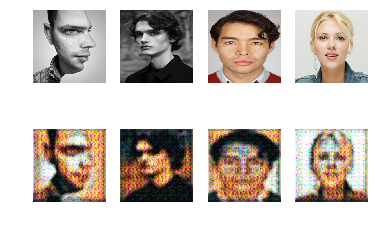

11/1000
0.49782327757704825 0.47863316003765377


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


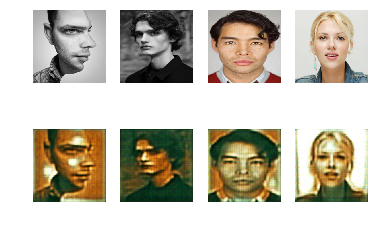

21/1000
0.3493691871297501 0.3413554367032789


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


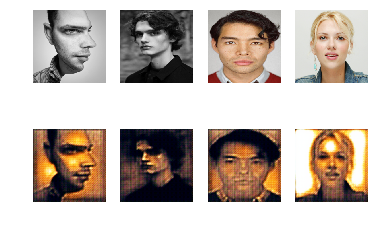

31/1000
0.3049622834438369 0.2982455162508857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


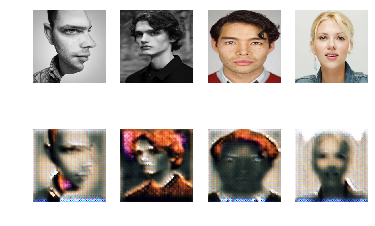

41/1000
0.3618897118916114 0.3136585754830213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


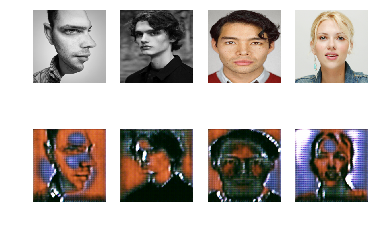

51/1000
0.3652415115918432 0.3206228441780522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


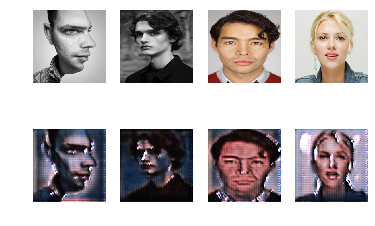

61/1000
0.36310422438241186 0.33823028496200486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


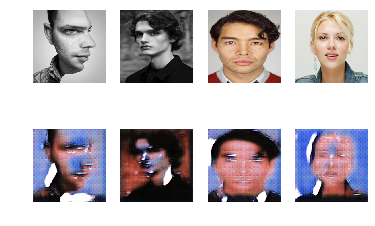

71/1000
0.38194783264771104 0.3187825521897702


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


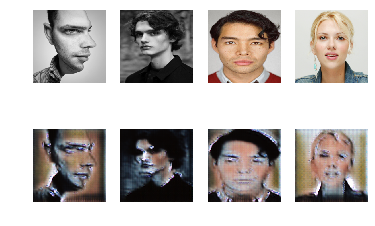

81/1000
0.3703718147284928 0.3232842259375112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


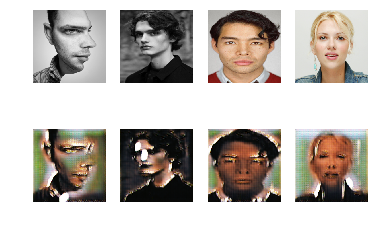

91/1000
0.3811603082521331 0.3279386514886504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


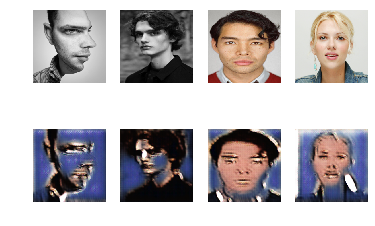

101/1000
0.2356695541225019 0.22828360760052288


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


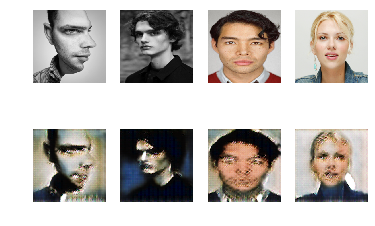

111/1000
0.37571126628401025 0.3324993899801657


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


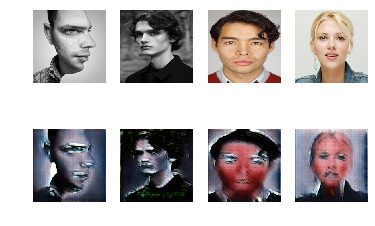

121/1000
0.35661769729285014 0.329064941610254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


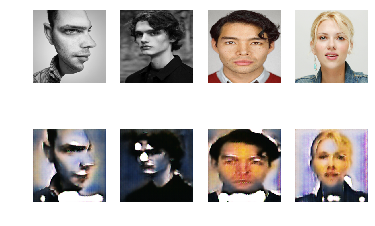

KeyboardInterrupt: ignored

In [41]:
gan_net.train(data_loader=people2dicaprio_data_loader, epochs=1000, lr=0.0001, lmb=10, test_set=X_test_set)

In [44]:
gan_net.save_models(path='cycle_gan/cycle_gan_models/people2dicaprio_model')

C:\Users\mpere\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\mpere\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResnetBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\mpere\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
